In [177]:
import gymnasium as gym
from gymnasium import spaces
from stable_baselines3 import PPO
from scipy.optimize import minimize, Bounds, LinearConstraint
import plotly.graph_objs as go
import pandas as pd
#import requests
import numpy as np
#import yfinance as yf
import matplotlib
%matplotlib inline
import random
import cvxpy as cp
import matplotlib.pyplot as plt
import datetime as dt
#from sklearn.linear_model import LinearRegression

In [178]:
def set_random_seed(seed):
    random.seed(seed)
    np.random.seed(seed)
    tf.random.set_seed(seed)
    torch.manual_seed(seed)
    if torch.cuda.is_available():
        torch.cuda.manual_seed_all(seed)

## For environemnt
if seed is not None:
        env.seed(seed)
        random.seed(seed)
        np.random.seed(seed)

In [179]:
price_data_path = '../data/prices.csv' 
prices_data = pd.read_csv(price_data_path)
prices_data = prices_data.dropna()

In [180]:
prices_data['HOUR'] = pd.to_datetime(prices_data['HOUR'])

In [181]:
prices_data

,HOUR,SYMBOL,PRICE
0,2023-01-10 00:00:00,RETH,1169.932315
1,2023-01-10 00:00:00,RETH,1410.355065
2,2023-01-10 00:00:00,SFRXETH,1343.795487
3,2023-01-10 00:00:00,WSTETH,1448.049037
4,2023-01-10 01:00:00,RETH,1409.274294
...,...,...,...
50047,2024-06-14 20:00:00,SFRXETH,3675.240000
50048,2024-06-14 20:00:00,WSTETH,3965.210000
50049,2024-06-14 21:00:00,RETH,3763.130000
50050,2024-06-14 21:00:00,SFRXETH,3699.200000


In [182]:
aggregated_data = prices_data.groupby(['HOUR', 'SYMBOL'], as_index=False).mean()

In [183]:
pivot_prices = aggregated_data.pivot(index='HOUR', columns='SYMBOL', values='PRICE').reset_index()

In [188]:
price_timeseries = pivot_prices.copy()

In [189]:
price_timeseries.set_index('HOUR', inplace=True)

In [190]:
price_timeseries.describe()

SYMBOL,RETH,SFRXETH,WSTETH
count,12526.000000,12526.000000,12526.000000
mean,2380.667729,2357.887618,2539.289865
std,791.835681,779.925816,835.224088
min,1289.049797,1218.893318,1447.077745
25%,1803.743409,1774.755158,1914.256202
50%,2004.433188,1976.704489,2131.698563
75%,2730.777245,2701.638037,2906.201561
max,4353.505000,7535.336365,4711.805155


In [191]:
price_timeseries

SYMBOL,RETH,SFRXETH,WSTETH
HOUR,,,
2023-01-10 00:00:00,1290.143690,1343.795487,1448.049037
2023-01-10 01:00:00,1289.049797,1343.044585,1447.077745
2023-01-10 02:00:00,1294.138380,1331.623488,1452.067734
2023-01-10 03:00:00,1293.660028,1329.479296,1451.492945
2023-01-10 04:00:00,1292.363131,1327.170486,1447.857928
...,...,...,...
2024-06-14 17:00:00,3861.890000,3753.580000,4059.110000
2024-06-14 18:00:00,3779.210000,3702.630000,3991.060000
2024-06-14 19:00:00,3766.860000,3685.080000,3972.560000


In [192]:
SFRXETH_price = price_timeseries['SFRXETH']

In [193]:
SFRXETH_price.to_csv('../data/sfrx.csv')

In [194]:
SFRXETH_price_pct = SFRXETH_price.pct_change()

In [195]:
anomolies = SFRXETH_price_pct.where(SFRXETH_price_pct.values > SFRXETH_price_pct.mean()*0.5).dropna()

In [196]:
anomolies.describe()

count    5937.000000
mean        0.005185
std         0.048592
min         0.000212
25%         0.001096
50%         0.002317
75%         0.004717
max         3.357390
Name: SFRXETH, dtype: float64

In [197]:
percentile_9 = anomolies.quantile(0.999)
anomalies_above_90th = anomolies > percentile_9


In [198]:
anomalies2 = anomalies_above_90th.where(anomalies_above_90th.values == True).dropna()

In [199]:
anomalies2

HOUR
2023-01-19 07:00:00    True
2023-01-29 12:00:00    True
2023-02-16 09:00:00    True
2023-04-18 07:00:00    True
2023-04-18 11:00:00    True
2023-04-20 02:00:00    True
Name: SFRXETH, dtype: object

In [200]:
anomalies_dates = anomalies2.index.unique()

In [212]:
anomalies_dates


DatetimeIndex(['2023-01-19 07:00:00', '2023-01-29 12:00:00',
               '2023-02-16 09:00:00', '2023-04-18 07:00:00',
               '2023-04-18 11:00:00', '2023-04-20 02:00:00'],
              dtype='datetime64[ns]', name='HOUR', freq=None)

In [202]:
weird_dates = price_timeseries.loc[anomalies_dates]

In [203]:
weird_dates['SFRXETH']

HOUR
2023-01-19 07:00:00    2058.231149
2023-01-29 12:00:00    3029.705400
2023-02-16 09:00:00    7535.336365
2023-04-18 07:00:00    3001.235718
2023-04-18 11:00:00    3909.498803
2023-04-20 02:00:00    3846.042838
Name: SFRXETH, dtype: float64

<Axes: xlabel='HOUR'>

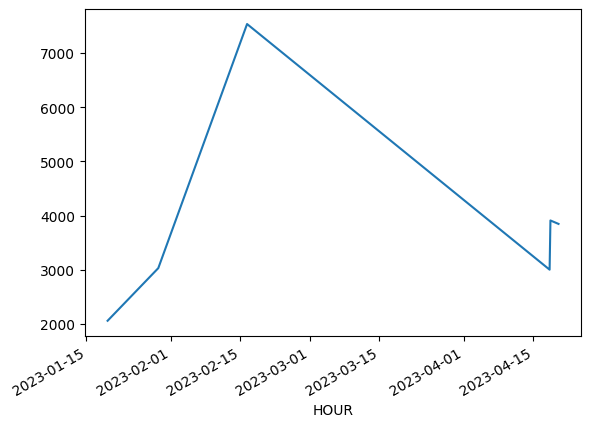

In [204]:
weird_dates['SFRXETH'].plot()

In [205]:
weird_dates

SYMBOL,RETH,SFRXETH,WSTETH
HOUR,,,
2023-01-19 07:00:00,1577.063131,2058.231149,2033.502222
2023-01-29 12:00:00,1579.570702,3029.705400,1781.067229
2023-02-16 09:00:00,1685.441709,7535.336365,1858.549844
2023-04-18 07:00:00,2181.065558,3001.235718,2337.444837
2023-04-18 11:00:00,2197.127842,3909.498803,2354.473916
2023-04-20 02:00:00,2029.211246,3846.042838,2179.549521


In [206]:
price_timeseries['SFRXETH_MA'] = price_timeseries['SFRXETH'].rolling(window=30, min_periods=1).mean()


In [207]:
price_timeseries = price_timeseries.reset_index()


In [208]:
price_timeseries

SYMBOL,HOUR,RETH,SFRXETH,WSTETH,SFRXETH_MA
0,2023-01-10 00:00:00,1290.143690,1343.795487,1448.049037,1343.795487
1,2023-01-10 01:00:00,1289.049797,1343.044585,1447.077745,1343.420036
2,2023-01-10 02:00:00,1294.138380,1331.623488,1452.067734,1339.487853
3,2023-01-10 03:00:00,1293.660028,1329.479296,1451.492945,1336.985714
4,2023-01-10 04:00:00,1292.363131,1327.170486,1447.857928,1335.022668
...,...,...,...,...,...
12521,2024-06-14 17:00:00,3861.890000,3753.580000,4059.110000,3792.625667
12522,2024-06-14 18:00:00,3779.210000,3702.630000,3991.060000,3789.202667
12523,2024-06-14 19:00:00,3766.860000,3685.080000,3972.560000,3785.105667
12524,2024-06-14 20:00:00,3758.570000,3675.240000,3965.210000,3780.951667


In [209]:
price_timeseries.loc[price_timeseries['HOUR'].isin(anomalies_dates), 'SFRXETH'] = price_timeseries.loc[price_timeseries['HOUR'].isin(anomalies_dates), 'SFRXETH_MA']


In [214]:
price_timeseries['HOUR']

0       2023-01-10 00:00:00
1       2023-01-10 01:00:00
2       2023-01-10 02:00:00
3       2023-01-10 03:00:00
4       2023-01-10 04:00:00
                ...        
12521   2024-06-14 17:00:00
12522   2024-06-14 18:00:00
12523   2024-06-14 19:00:00
12524   2024-06-14 20:00:00
12525   2024-06-14 21:00:00
Name: HOUR, Length: 12526, dtype: datetime64[ns]

In [211]:
print(pivot_prices[pivot_prices['HOUR'].isin(weird_dates)])


Empty DataFrame
Columns: [HOUR, RETH, SFRXETH, WSTETH]
Index: []
